### Using SVD to factorise user-game-matrix and get another representation for users and games

In [1]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_matrix
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from copy import *

%load_ext autoreload
%autoreload 2

In [3]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 20 # change to set one

In [4]:
# filter data with the minimum reviews
filtered_avis = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_avis)

11201 10549
1259 1267
904 1158
873 1140
869 1136
868 1135


In [ ]:
# see the array without truncation, to truncate, threshold = 0
# np.set_printoptions(threshold=np.inf) 

The function svd compute SVD on array. Svds compute for sparse matrix, we'll check on the singular values returned using the array matrix, to determine the k best singular values to compute using sparse matrix. 

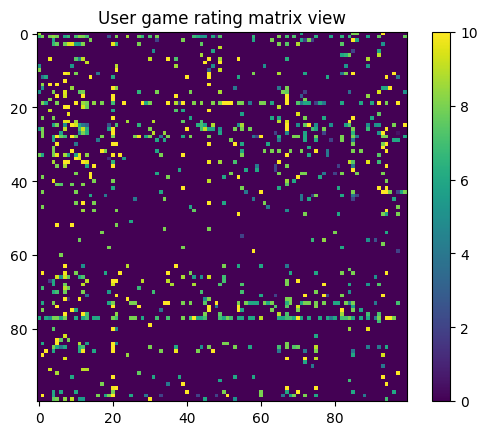

In [6]:
# transforming the matrix as array for svd
mat_ug = user_game_ratings.toarray()
plt.imshow(mat_ug[:100,:100])
plt.title("User game rating matrix view")
plt.colorbar()

**SVD matrix**

`U` representation for users: cols = latent features, rows = users profil, index corresponding to mat_ug users

`D` contains the diagonal singular values of diagonal matrix. Represent how much one latent feature in U and V influence mat_ug. D is sorted descending

`Vt` representation for games : rows = latent features, columns = games, index matching mat_ug games

In [ ]:
# creating svd matrix such mat_ug = U @ D @ Vt

# U, D, Vt = svd(mat_ug)
# np.save("generated_data/U.npy", U)
# np.save("generated_data/D.npy", D)
# np.save("generated_data/Vt.npy", Vt) 

U, D, Vt = np.load("generated_data/U.npy"), np.load("generated_data/D.npy"), np.load("generated_data/Vt.npy") 

In [9]:
# shape of the matrixes
U.shape, D.shape, Vt.shape, mat_ug.shape

((868, 868), (868,), (1135, 1135), (868, 1135))

In [11]:
# we test to see if we can reconstruct our mat_ug matrix

diag = np.zeros((U.shape[0], Vt.shape[0])) # create the diagonal matrix
np.fill_diagonal(diag, D)

UDVt = U @ diag @ Vt
UDVt.shape, np.allclose(UDVt, mat_ug) # allclose check to a certain threshold if matrixes are similar

((868, 1135), True)

**Visualisation of the decomposed matrix components**

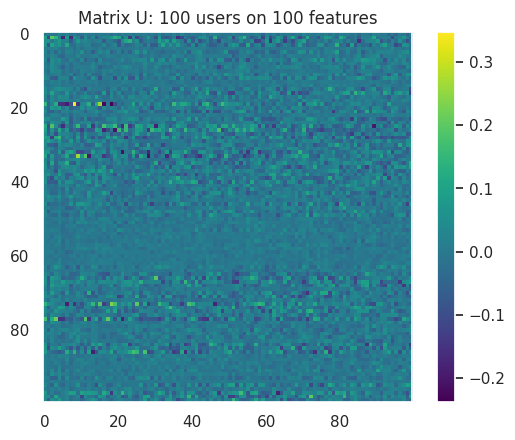

In [77]:
# we visualise the matrix U: U[i][j] represent is user's i association with feature j
plt.imshow(U[:100, :100], cmap="viridis")
plt.grid(False)
plt.title("Matrix U: 100 users on 100 features")
plt.colorbar()

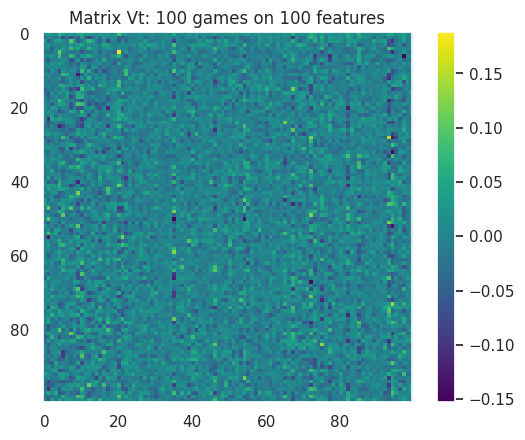

In [76]:
# we visualise the matrix Vt: Vt[i][j] represent is game's j association with feature i
plt.imshow(Vt[:100, :100], cmap="viridis")
plt.grid(False)
plt.title("Matrix Vt: 100 games on 100 features")
plt.colorbar()

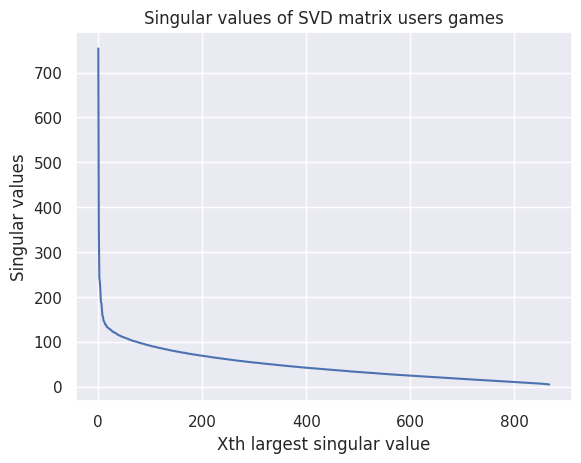

In [ ]:
# first largest singular values
sns.set_theme()
sns.lineplot(D)
plt.title("Singular values of SVD matrix users games")
plt.xlabel("Xth largest singular value")
plt.ylabel("Singular values")
plt.savefig("images/SVD/sing_val.png")
plt.show()

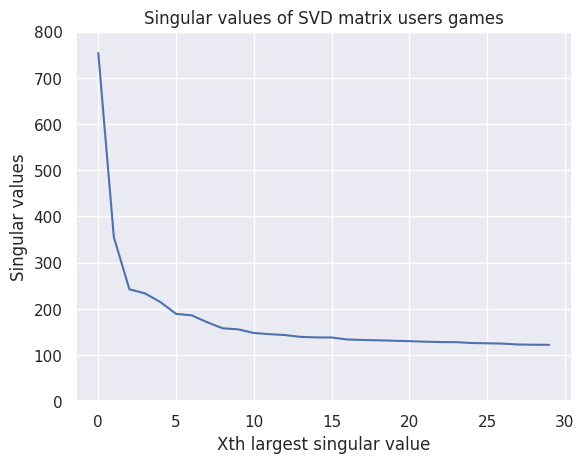

In [79]:
# zoom in
sns.set_theme()
sns.lineplot(D[:30])
plt.ylim(0, 800)
plt.title("Singular values of SVD matrix users games")
plt.xlabel("Xth largest singular value")
plt.ylabel("Singular values")
plt.savefig("images/SVD/sing_val_top30.png")
plt.show()

We can choose a `k` ranging from 5 to 20. Have to make tests for different k. Let's compare with SVD on sparse matrix.

In [ ]:
# choosing k = 10, 10 best latent features
Us, Ds, Vts = svds(user_game_ratings, k=30)
Us.shape, Ds.shape, Vts.shape, type(Us), type(Ds), type(Vts) # return nparray matrix

((868, 30), (30,), (30, 1135), numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
# Ds is in ascending order, but they are similar
np.allclose(Ds[::-1], D[:30])

True

**Visualisation of the components**

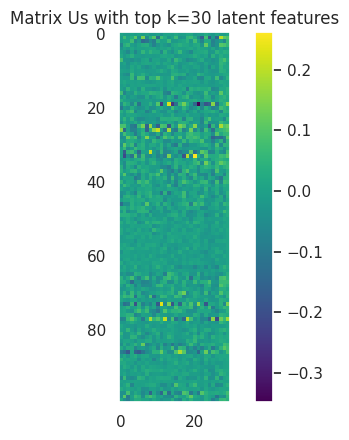

In [99]:
# we visualise the matrix Us: Us[i][j] represent is user's i association with feature j
plt.imshow(Us[:100], cmap="viridis")
plt.grid(False)
plt.title("Matrix Us with top k=30 latent features")
plt.colorbar()

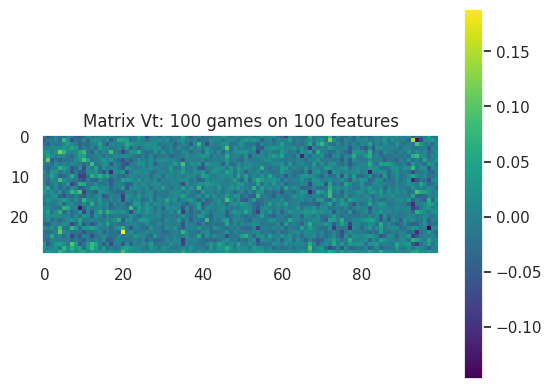

In [ ]:
# we visualise the matrix Vts: Vts[i][j] represent is game's j association with feature i
plt.imshow(Vts[:,:100], cmap="viridis")
plt.grid(False)
plt.title("Matrix Vt: with top k=30 features")
plt.colorbar()

In [ ]:
# somme sur colonnes de U?

In [102]:
# if i used k = 2 and plotted the data
Us, Ds, Vts = svds(user_game_ratings, k=2)

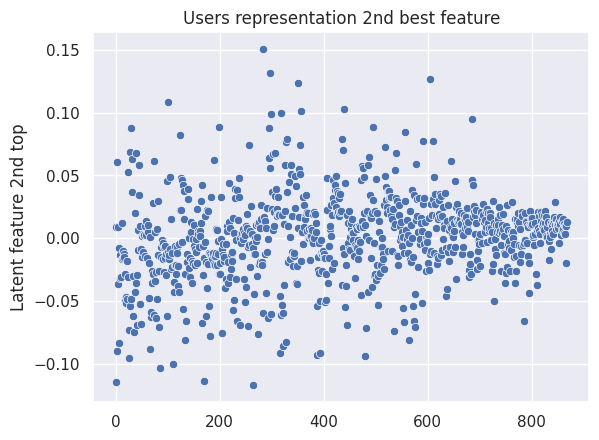

In [138]:
sns.scatterplot([pt[0] for pt in Us])
plt.title("Users representation 2nd best feature")
plt.xlabel("")
plt.ylabel("Latent feature 2nd top")
plt.show()

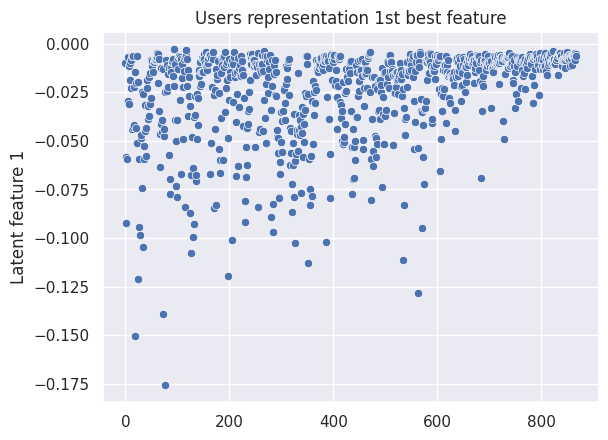

In [139]:
sns.scatterplot([pt[1] for pt in Us])
plt.title("Users representation 1st best feature")
plt.xlabel("")
plt.ylabel("Latent feature 1")
plt.show()

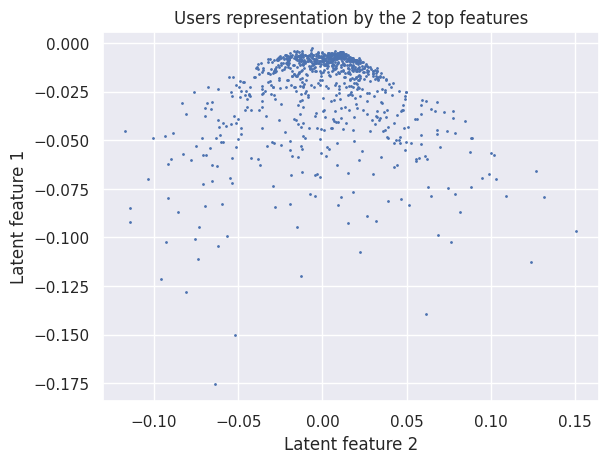

In [140]:
plt.scatter([pt[0] for pt in Us], [pt[1] for pt in Us], s=1)
plt.title("Users representation by the 2 top features")
plt.xlabel("Latent feature 2")
plt.ylabel("Latent feature 1")
plt.show() # we observe a  great concentration on 0 -> a lot of users tend to not be associated with the 2 features 